<a href="https://colab.research.google.com/github/Shubhkj/Lunar-Lander/blob/main/DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install swig

In [ ]:
pip install gym[box2d]

In [ ]:
# import dependency
import gym
from gym import wrappers

import os
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# path
CURR_PATH = os.path.abspath('')
OUTPUT_PATH = os.path.join(CURR_PATH, 'output')
RANDOM_AGENT_PATH = os.path.join(OUTPUT_PATH, 'random_agent')
DDQN_AGENT_PATH = os.path.join(OUTPUT_PATH, 'ddqn_agent')
DDQN_CHECKPOINT_PATH = os.path.join(DDQN_AGENT_PATH, 'policy_model_checkpoint.pth')
DDQN_RESULT_IMG_PATH = os.path.join(DDQN_AGENT_PATH, 'result_img_{}.png')

for p in [RANDOM_AGENT_PATH, DDQN_AGENT_PATH]:
    if not os.path.exists(p):
        os.makedirs(p)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make('LunarLander-v2')
n_states, n_actions = env.observation_space.shape[0], env.action_space.n
print('state space: {}'.format(n_states))
print('action space: {}'.format(n_actions))

state space: 8
action space: 4


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
class DDQN_Graph(nn.Module):
    """
    Deep Reinforcement Learning with Double Q-Learning by Hasselt et al. (2016)
    Double Deep Q-Network Model Graph
    The neural network is a function from state space $R^{n_states}$ to action space $R^{n_actions}$

    """
    def __init__(self, n_states, n_actions, hidden_size=32):
        super(DDQN_Graph, self).__init__()
        self.n_actions = n_actions
        self.half_hidden_size = int(hidden_size/2)
        # hidden representation
        self.dense_layer_1 = nn.Linear(n_states, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        # V(s)
        self.v_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.v_layer_2 = nn.Linear(self.half_hidden_size, 1)
        # A(s, a)
        self.a_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.a_layer_2 = nn.Linear(self.half_hidden_size, n_actions)

    def forward(self, state):
        # state: batch_size, state_size
        # x: batch_size, hidden_size
        x = F.relu(self.dense_layer_1(state))
        # x: batch_size, hidden_size
        x = F.relu(self.dense_layer_2(x))
        # v: batch_size, half_hidden_size
        v = F.relu(self.v_layer_1(x))
        # v: batch_size, 1
        v = self.v_layer_2(v)
        # a: batch_size, half_hidden_size
        a = F.relu(self.a_layer_1(x))
        # a: batch_size, action_size
        a = self.a_layer_2(a)

        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        # batch_size, action_size
        return v + a - a.mean(dim=-1, keepdim=True).expand(-1, self.n_actions)

In [ ]:
class ReplayMemory():
    """
    Replay memory records previous observations for the agent to learn later
    by sampling from the memory randomly
    """
    def __init__(self, capacity):
        super(ReplayMemory, self).__init__()
        self.capacity = capacity
        # to avoid empty memory list to insert transitions
        self.memory = [None] * capacity
        self.position = 0
        self.Transition = namedtuple('Transition',
                                     ('state', 'action', 'reward', 'next_state', 'done'))

    def size(self):
        return len(self.memory) - self.memory.count(None)

    def push(self, *args):
        # save a transition at a certain position of the memory
        self.memory[self.position] = self.Transition(*args)
        # update position
        self.position = (self.position + 1) % self.capacity

    def pull(self):
        return [exp for exp in self.memory if exp is not None]

    def sample(self, batch_size):
        exps = random.sample(self.pull(), batch_size)
        states = torch.tensor(np.vstack([e.state for e in exps if e is not None])).float()
        actions = torch.tensor(np.vstack([e.action for e in exps if e is not None])).long()
        rewards = torch.tensor(np.vstack([e.reward for e in exps if e is not None])).float()
        next_states = torch.tensor(np.vstack([e.next_state for e in exps if e is not None])).float()
        dones = torch.tensor(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DDQN_Agent():
    """docstring for ddqn_agent"""
    def __init__(self, n_states, n_actions, batch_size, hidden_size, memory_size,
                 update_step, learning_rate, gamma, tau):
        super(DDQN_Agent, self).__init__()
        # state space dimension
        self.n_states = n_states
        # action space dimension
        self.n_actions = n_actions
        # configuration
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.update_step = update_step
        self.lr = learning_rate
        self.gamma = gamma
        self.tau = tau
        # check cpu or gpu
        self.setup_gpu()
        # initialize model graph
        self.setup_model()
        # initialize optimizer
        self.setup_opt()
        # enable Replay Memory
        self.memory = ReplayMemory(memory_size)
        # others
        self.prepare_train()

    def setup_gpu(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def setup_model(self):
        self.policy_model = DDQN_Graph(
            self.n_states,
            self.n_actions,
            self.hidden_size).to(self.device)
        self.target_model = DDQN_Graph(
            self.n_states,
            self.n_actions,
            self.hidden_size).to(self.device)

    def setup_opt(self):
        self.opt = torch.optim.Adam(self.policy_model.parameters(), lr=self.lr)

    def prepare_train(self):
        self.steps = 0

    def act(self, state, epsilon):
        # take an action for a time step
        # state: 1, state_size
        state = torch.tensor(state).reshape(1, -1).to(self.device)
        # inference by policy model
        self.policy_model.eval()
        with torch.no_grad():
            # action_vs: 1, action_size
            action_vs = self.policy_model(state)
        self.policy_model.train()
        # return action: 1
        # epsilon greedy search
        if np.random.random() > epsilon:
            return np.argmax(action_vs.cpu().detach().numpy())
        else:
            return np.random.randint(self.n_actions)

    def step(self, s, a, r, s_, done):
        # add one observation to memory
        self.memory.push(s, a, r, s_, done)
        # update model for every certain steps
        self.steps = (self.steps + 1) % self.update_step
        if self.steps == 0 and self.memory.size() >= self.batch_size:
            exps = self.memory.sample(self.batch_size)
            self.learn(exps)
        else:
            pass

    def learn(self, exps, soft_copy=True):

        for item in exps:
            item.to(self.device)
        # states: batch_size, state_size
        # actions: batch_size, 1
        # rewards: batch_size, 1
        # next_states: batch_size, state_size
        # dones: batch_size, 1
        states, actions, rewards, next_states, dones = exps
        # target side
        _, next_idx = self.policy_model(next_states).detach().max(1)
        # action values: batch_size, action_size
        target_next_action_vs = self.target_model(next_states).detach().gather(1, next_idx.unsqueeze(1))
        # Q values: batch_size, 1
        # Q = reward + (gamma * Q[next state][next action]) for not done
        target_q_vs = rewards + (self.gamma * target_next_action_vs * (1 - dones))
        # policy side
        # Q values: batch_size, 1
        policy_q_vs = self.policy_model(states).gather(1, actions)
        # compute MSE loss
        loss = F.mse_loss(policy_q_vs, target_q_vs)
        # update policy network
        self.opt.zero_grad()
        loss.backward()
        # gradient clamping
        for p in self.policy_model.parameters():
            p.grad.data.clamp_(-1, 1)
        self.opt.step()
        if soft_copy:
            # update target network via soft copy with ratio tau
            # θ_target = τ*θ_local + (1 - τ)*θ_target
            for tp, lp in zip(self.target_model.parameters(), self.policy_model.parameters()):
                tp.data.copy_(self.tau*lp.data + (1.0-self.tau)*tp.data)
        else:
            # update target network via hard copy
            self.target_model.load_state_dict(self.policy_model.state_dict())

In [ ]:
# initial definition
batch_size = 128
hidden_size = 128
memory_size = int(1e5)
update_step = 4
learning_rate = 5e-4
gamma = 0.99
tau = 1e-2

n_episodes = 1000
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.004
rewards_window_size = 100

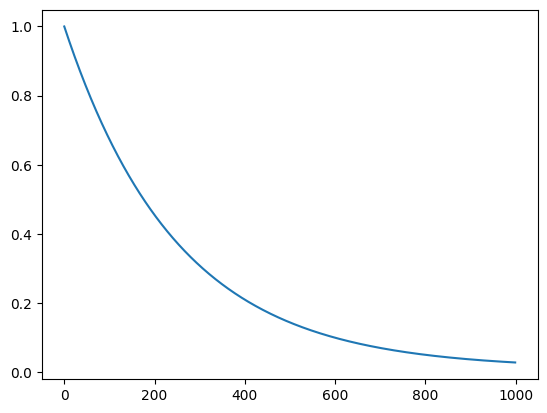

In [ ]:
# initialize epsilon values for greedy search
epsilon_array = np.zeros((n_episodes))
for i in range(n_episodes):
    epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*i)
    epsilon_array[i] = epsilon

plt.plot(epsilon_array)
plt.show()

In [ ]:
# training process
# initialize the DDQN agent given a configuration
agent = DDQN_Agent(n_states,
                   n_actions,
                   batch_size,
                   hidden_size,
                   memory_size,
                   update_step,
                   learning_rate,
                   gamma,
                   tau)

def ddqn_learn_op(n_episodes, rewards_window_size, epsilon_array):
    best_avg_rewards = 100.
    total_rewards = []
    rewards_deque = deque(maxlen=rewards_window_size)
    t = trange(n_episodes)
    for episode in t:
        # initialize the state
        cur_state = env.reset()
        done = False
        rewards = 0
        epsilon = epsilon_array[episode]
        while not done:
            action = agent.act(cur_state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.step(cur_state, action, reward, next_state, done)
            cur_state = next_state
            rewards += reward
        # update information
        total_rewards.append(rewards)
        rewards_deque.append(rewards)
        avg_rewards = np.mean(rewards_deque)
        t.set_description(
            'Episode {} Epsilon {:.2f} Reward {:.2f} Avg_Reward {:.2f} Best_Avg_Reward {:.2f}'.format(
                episode + 1, epsilon, rewards, avg_rewards, best_avg_rewards))
        t.refresh()
        # evaluation
        if avg_rewards >= best_avg_rewards:
            best_avg_rewards = avg_rewards
            torch.save(agent.policy_model.state_dict(), DDQN_CHECKPOINT_PATH)
        # the game is solved by earning more than +200 rewards for a single episode
        if best_avg_rewards > 200:
            break
    return total_rewards, rewards_deque

In [ ]:
pip install pyglet==1.5.11

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# a list of rewards for each episode
# and a deque of rewards for latest episode given a certain rewards window size
# training may take around 30 mins on CPU
train_rewards, train_rewards_deque = ddqn_learn_op(n_episodes, rewards_window_size, epsilon_array)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 543 Epsilon 0.12 Reward 286.95 Avg_Reward 200.42 Best_Avg_Reward 199.76:  54%|█████▍    | 542/1000 [27:29<23:13,  3.04s/it]


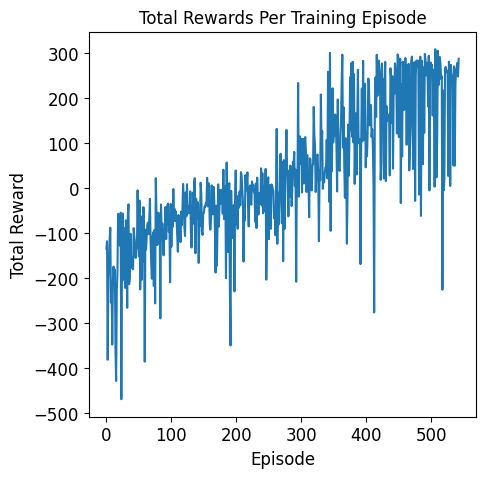

In [ ]:
# show rewards change in training
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(train_rewards)
plt.ylabel('Total Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Total Rewards Per Training Episode', fontsize=12)
# plt.savefig(DDQN_RESULT_IMG_PATH.format(0), dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
test_episodes=100
test_reward_array = np.zeros(100)
agent = DDQN_Agent(n_states,
                   n_actions,
                   batch_size,
                   hidden_size,
                   memory_size,
                   update_step,
                   learning_rate,
                   gamma,
                   tau)
# load check point to restore the model
agent.policy_model.load_state_dict(
    torch.load(DDQN_CHECKPOINT_PATH, map_location=agent.device))

t = trange(test_episodes, leave=True)
for episode in t:
    state = env.reset()
    done = False
    rewards = 0.
    while not done:
        # disable epsilon greedy search
        action = agent.act(state, epsilon=0)
        state, reward, done, _ = env.step(action)
        rewards += reward
    t.set_description('Episode {:.2f} Reward {:.2f}'.format(episode + 1, rewards))
    t.refresh()
    test_reward_array[episode] = rewards
env.close()

Episode 100.00 Reward 284.99: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


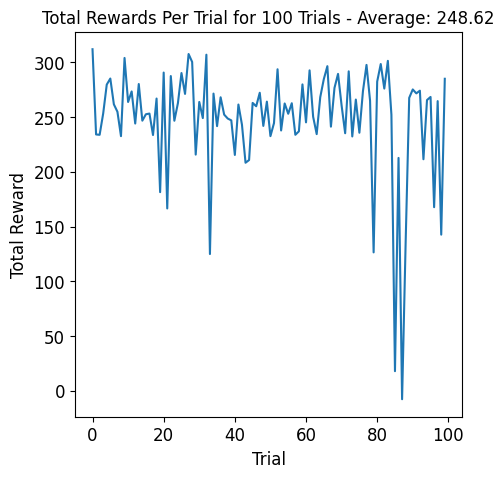

In [ ]:
avg_test_reward = round(np.mean(test_reward_array), 2)
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(test_reward_array)
plt.ylabel('Total Reward', fontsize=12)
plt.xlabel('Trial', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Total Rewards Per Trial for 100 Trials - Average: {:.2f}'.format(avg_test_reward),
          fontsize=12)
# plt.savefig(DDQN_RESULT_IMG_PATH.format(1), dpi=100, bbox_inches='tight')
plt.show()